<a href="https://colab.research.google.com/github/dahalrajesh/100-days-Python-Code/blob/master/mutag_GNN%20network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Required Libraries**

In [24]:
!pip install torch torchvision torchaudio
!pip install torch-geometric

# **Import LIbraries:**
1.PyTorch and torch.nn for defining neural networks and optimizing them.
2.torch_geometric for graph neural network operations.
matplotlib and networkx for visualizing graphs.

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv,global_mean_pool
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from torch_geometric.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [50]:
#load theh cora dataset
dataset=TUDataset(root='data/TUDataset',name='MUTAG')
torch.manual_seed(42)
dataset=dataset.shuffle()
train_dataset=dataset[:150]
test_dataset=dataset[150:]
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [51]:
# Define the GCN model with intermediate outputs
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch, return_intermediate=False):
        x_init = x  # Save initial node features

        x1 = self.conv1(x, edge_index).relu()  # After 1st layer
        x2 = self.conv2(x1, edge_index).relu() # After 2nd layer

        pooled = global_mean_pool(x2, batch)
        out = self.fc(pooled)

        if return_intermediate:
            return out, x_init, x1, x2
        return out

# Model, optimizer, loss function (same as yours)
model = GCN(dataset.num_node_features, 64, dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



**Training Function**

In [52]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


**Evaluation Function**

In [53]:
def evaluate(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, prec, rec, f1, all_labels, all_preds

Training Loop with Metrics

In [54]:
epochs = 50
train_losses = []
test_accs, test_precs, test_recs, test_f1s = [], [], [], []

for epoch in range(1, epochs+1):
    loss = train()
    acc, prec, rec, f1, labels, preds = evaluate(test_loader)

    train_losses.append(loss)
    test_accs.append(acc)
    test_precs.append(prec)
    test_recs.append(rec)
    test_f1s.append(f1)

    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

Epoch 01 | Loss: 0.6197 | Acc: 0.5526 | Prec: 0.3054 | Rec: 0.5526 | F1: 0.3934
Epoch 02 | Loss: 0.6244 | Acc: 0.5526 | Prec: 0.3054 | Rec: 0.5526 | F1: 0.3934
Epoch 03 | Loss: 0.6064 | Acc: 0.5526 | Prec: 0.3054 | Rec: 0.5526 | F1: 0.3934
Epoch 04 | Loss: 0.5936 | Acc: 0.5526 | Prec: 0.3054 | Rec: 0.5526 | F1: 0.3934
Epoch 05 | Loss: 0.5873 | Acc: 0.5526 | Prec: 0.3054 | Rec: 0.5526 | F1: 0.3934
Epoch 06 | Loss: 0.5646 | Acc: 0.5789 | Prec: 0.7610 | Rec: 0.5789 | F1: 0.4499
Epoch 07 | Loss: 0.5537 | Acc: 0.5789 | Prec: 0.7610 | Rec: 0.5789 | F1: 0.4499
Epoch 08 | Loss: 0.5570 | Acc: 0.5789 | Prec: 0.7610 | Rec: 0.5789 | F1: 0.4499
Epoch 09 | Loss: 0.5287 | Acc: 0.6579 | Prec: 0.7182 | Rec: 0.6579 | F1: 0.6116
Epoch 10 | Loss: 0.5030 | Acc: 0.6579 | Prec: 0.7182 | Rec: 0.6579 | F1: 0.6116
Epoch 11 | Loss: 0.5025 | Acc: 0.6316 | Prec: 0.6290 | Rec: 0.6316 | F1: 0.6230
Epoch 12 | Loss: 0.4972 | Acc: 0.6579 | Prec: 0.7182 | Rec: 0.6579 | F1: 0.6116
Epoch 13 | Loss: 0.5109 | Acc: 0.6316 | 

In [55]:
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=[f"Class {i}" for i in np.unique(labels)]))


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.41      0.54        17
     Class 1       0.66      0.90      0.76        21

    accuracy                           0.68        38
   macro avg       0.72      0.66      0.65        38
weighted avg       0.71      0.68      0.66        38



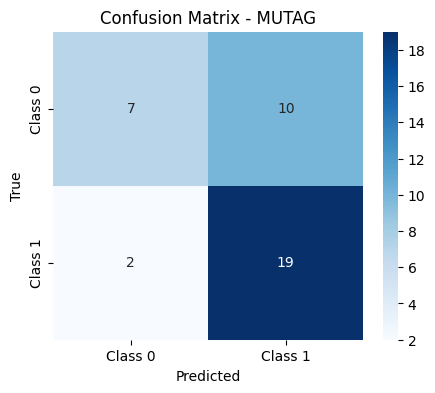

In [56]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in np.unique(labels)], yticklabels=[f"Class {i}" for i in np.unique(labels)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MUTAG")
plt.savefig("mutag_confusion_matrix.png", dpi=300)
plt.show()

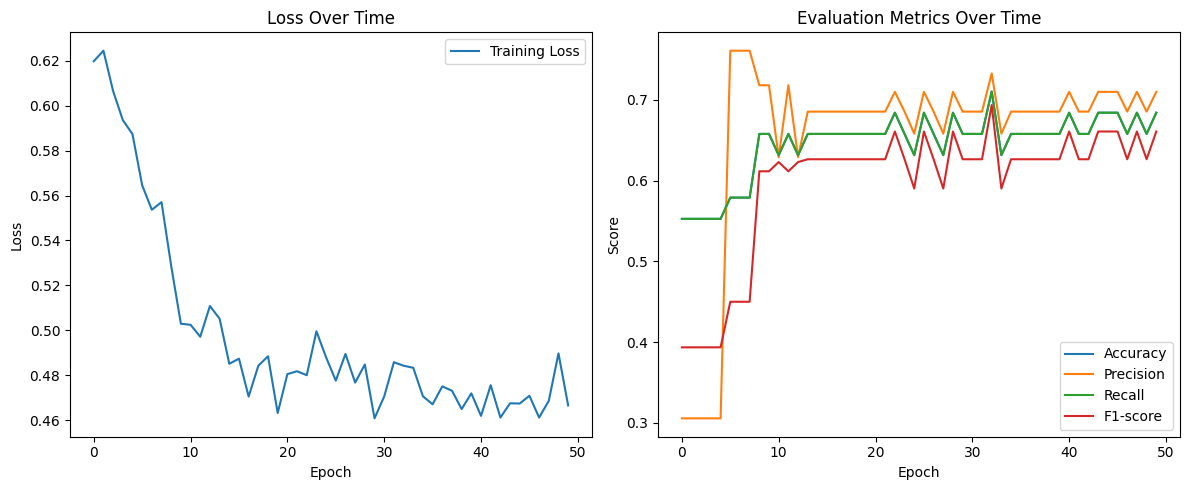

In [57]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accs, label='Accuracy')
plt.plot(test_precs, label='Precision')
plt.plot(test_recs, label='Recall')
plt.plot(test_f1s, label='F1-score')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Time")
plt.legend()

plt.tight_layout()
plt.savefig("mutag_metrics.png", dpi=300)
plt.show()

Visualization function

In [58]:
def plot_graph_features(data, node_features, title):
    import networkx as nx
    from torch_geometric.utils import to_networkx

    G = to_networkx(data, to_undirected=True)
    node_color = node_features.detach().cpu().numpy()

    if node_color.ndim > 1 and node_color.shape[1] > 1:
        node_color = node_color[:, 0]  # First feature for coloring

    plt.figure(figsize=(4, 4))
    nx.draw(G, node_color=node_color, cmap="viridis", with_labels=True, node_size=500)
    plt.title(title)
    plt.show()


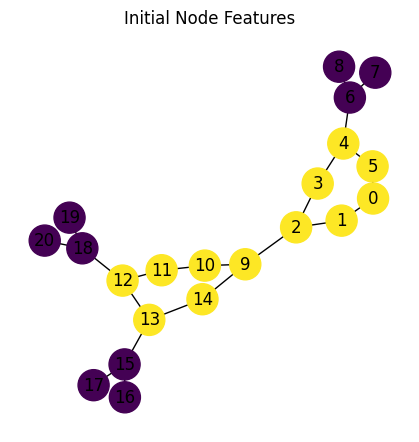

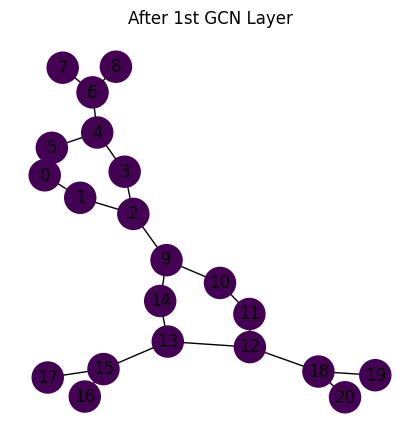

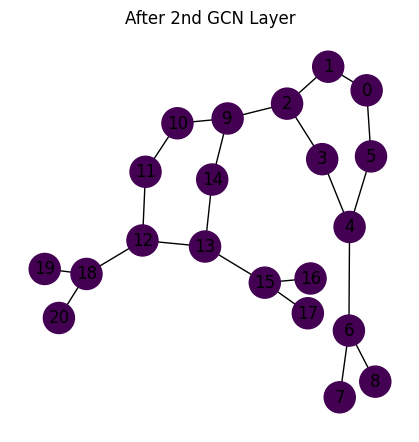

In [59]:
# Pick one sample molecule graph
sample_data = dataset[0]
sample_data = sample_data.to('cpu')

# Get the intermediate outputs without training
model.eval()
with torch.no_grad():
    _, x_init, x_after1, x_after2 = model(
        sample_data.x, sample_data.edge_index, sample_data.batch, return_intermediate=True
    )

# Plot graphs
plot_graph_features(sample_data, x_init, "Initial Node Features")
plot_graph_features(sample_data, x_after1, "After 1st GCN Layer")
plot_graph_features(sample_data, x_after2, "After 2nd GCN Layer")
